## Classification without contrastive learning pretraining

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE
import numpy as np
sys.path.append('/home/gridsan/ckoevesdi/.local/lib/python3.9/site-packages/')
from pytorch_metric_learning import losses

sys.path.append('/home/gridsan/ckoevesdi/PooledStatisticsMetamers/poolstatmetamer/')
import utils.statnetencoder as sne
import importlib
import imp
import torch.nn.functional as F

#!wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py

#sys.path.append(r'C:\Users\chris\Documents\MIT\Statistics_analysis_code\PyTorchSteerablePyramid')
sys.path.append('/home/gridsan/ckoevesdi/PyTorchSteerablePyramid/')
import steerable
import steerable.utils as utils
from steerable.SCFpyr_PyTorch import SCFpyr_PyTorch

torch.manual_seed(16)

#use GPU 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
dtd_folder = 'home/gridsan/ckoevesdi/data/OT/dtd_torch/dtd/'

cuda:0


In [2]:
loading_transforms = transforms.Compose([
    transforms.CenterCrop(size=256),
    transforms.Grayscale(),
    transforms.ToTensor(),  # This will also convert the image from [0, 255] to [0.0, 1.0]
    transforms.ConvertImageDtype(torch.float32)
])

#use training set for now
class_dtd_dataset = torchvision.datasets.DTD(root='/home/gridsan/ckoevesdi/data/OT/dtd_torch/', split='train', 
                                             partition=10, 
                                       transform=loading_transforms, target_transform=None,
                                       download=False) #ah das datenset muss so aussehen wie es auf der website auch ist, deswegen kann man auch download false machen
# Define the batch size (Change this based on your requirements)
batch_size = 1

# Create a DataLoader
classification_dataloader = DataLoader(
    class_dtd_dataset,
    batch_size=batch_size,
    shuffle=False
)
tensor2pil_transform = transforms.ToPILImage()

In [3]:
ostat_labels = ['mean', 'variance', 'bandpass_variance 0', 'variance 1', 'skew 1', 'kurtosis 1', 'variance 2', 'skew 2', 'kurtosis 2', 'variance 3', 'skew 3', 'kurtosis 3', 'variance 4', 'skew 4', 'kurtosis 4', 'variance 5', 'skew 5', 'kurtosis 5', 'edge_mean 1 0', 'edge_variance 1 0', 'edge_correlation (1, 2) 0', 'edge_stop 1 0', 'edge_mean 1 1', 'edge_variance 1 1', 'edge_correlation (1, 2) 1', 'edge_stop 1 1', 'edge_mean 1 2', 'edge_variance 1 2', 'edge_correlation (1, 2) 2', 'edge_stop 1 2', 'edge_mean 1 3', 'edge_variance 1 3', 'edge_correlation (1, 2) 3', 'edge_stop 1 3', 'edge_correlation 1 (0, 1)', 'edge_correlation 1 (0, 2)', 'edge_correlation 1 (0, 3)', 'edge_correlation 1 (1, 2)', 'edge_correlation 1 (1, 3)', 'edge_correlation 1 (2, 3)', 'edge_mean 2 0', 'edge_variance 2 0', 'edge_correlation (2, 3) 0', 'edge_stop 2 0', 'edge_mean 2 1', 'edge_variance 2 1', 'edge_correlation (2, 3) 1', 'edge_stop 2 1', 'edge_mean 2 2', 'edge_variance 2 2', 'edge_correlation (2, 3) 2', 'edge_stop 2 2', 'edge_mean 2 3', 'edge_variance 2 3', 'edge_correlation (2, 3) 3', 'edge_stop 2 3', 'edge_correlation 2 (0, 1)', 'edge_correlation 2 (0, 2)', 'edge_correlation 2 (0, 3)', 'edge_correlation 2 (1, 2)', 'edge_correlation 2 (1, 3)', 'edge_correlation 2 (2, 3)', 'edge_mean 3 0', 'edge_variance 3 0', 'edge_correlation (3, 4) 0', 'edge_stop 3 0', 'edge_mean 3 1', 'edge_variance 3 1', 'edge_correlation (3, 4) 1', 'edge_stop 3 1', 'edge_mean 3 2', 'edge_variance 3 2', 'edge_correlation (3, 4) 2', 'edge_stop 3 2', 'edge_mean 3 3', 'edge_variance 3 3', 'edge_correlation (3, 4) 3', 'edge_stop 3 3', 'edge_correlation 3 (0, 1)', 'edge_correlation 3 (0, 2)', 'edge_correlation 3 (0, 3)', 'edge_correlation 3 (1, 2)', 'edge_correlation 3 (1, 3)', 'edge_correlation 3 (2, 3)', 'edge_mean 4 0', 'edge_variance 4 0', 'edge_stop 4 0', 'edge_mean 4 1', 'edge_variance 4 1', 'edge_stop 4 1', 'edge_mean 4 2', 'edge_variance 4 2', 'edge_stop 4 2', 'edge_mean 4 3', 'edge_variance 4 3', 'edge_stop 4 3', 'edge_correlation 4 (0, 1)', 'edge_correlation 4 (0, 2)', 'edge_correlation 4 (0, 3)', 'edge_correlation 4 (1, 2)', 'edge_correlation 4 (1, 3)', 'edge_correlation 4 (2, 3)', 'phase_correlation 1 er (0, 1)', 'phase_correlation 1 er (0, 2)', 'phase_correlation 1 er (0, 3)', 'phase_correlation 1 er (1, 2)', 'phase_correlation 1 er (1, 3)', 'phase_correlation 1 er (2, 3)', 'phase_correlation (1, 2) ei*di 0', 'phase_correlation (1, 2) er*di 0', 'phase_correlation (1, 2) ei*di 1', 'phase_correlation (1, 2) er*di 1', 'phase_correlation (1, 2) ei*di 2', 'phase_correlation (1, 2) er*di 2', 'phase_correlation (1, 2) ei*di 3', 'phase_correlation (1, 2) er*di 3', 'phase_correlation 2 er (0, 1)', 'phase_correlation 2 er (0, 2)', 'phase_correlation 2 er (0, 3)', 'phase_correlation 2 er (1, 2)', 'phase_correlation 2 er (1, 3)', 'phase_correlation 2 er (2, 3)', 'phase_correlation (2, 3) ei*di 0', 'phase_correlation (2, 3) er*di 0', 'phase_correlation (2, 3) ei*di 1', 'phase_correlation (2, 3) er*di 1', 'phase_correlation (2, 3) ei*di 2', 'phase_correlation (2, 3) er*di 2', 'phase_correlation (2, 3) ei*di 3', 'phase_correlation (2, 3) er*di 3', 'phase_correlation 3 er (0, 1)', 'phase_correlation 3 er (0, 2)', 'phase_correlation 3 er (0, 3)', 'phase_correlation 3 er (1, 2)', 'phase_correlation 3 er (1, 3)', 'phase_correlation 3 er (2, 3)', 'phase_correlation (3, 4) ei*di 0', 'phase_correlation (3, 4) er*di 0', 'phase_correlation (3, 4) ei*di 1', 'phase_correlation (3, 4) er*di 1', 'phase_correlation (3, 4) ei*di 2', 'phase_correlation (3, 4) er*di 2', 'phase_correlation (3, 4) ei*di 3', 'phase_correlation (3, 4) er*di 3', 'phase_correlation 4 er (0, 1)', 'phase_correlation 4 er (0, 2)', 'phase_correlation 4 er (0, 3)', 'phase_correlation 4 er (1, 2)', 'phase_correlation 4 er (1, 3)', 'phase_correlation 4 er (2, 3)']

In [6]:
import utils.brucenet as bn
brucy = bn.BruceNet(pooling_region_size=1e20, pyramid_params=False, dummy_img = torch.zeros(20,
                                     1,
                                     256,
                                     256)).to(device)

Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


In [7]:
all_statistics = []

for j, (texture_batch, labels) in enumerate(classification_dataloader):
    # Assuming texture_batch has a shape of [20, 5, 1, 128, 128]
    #print(texture_batch.shape)
    output = texture_batch.to(device)
    output = torch.stack([output, output]).squeeze(1)
    #print(output.shape)
    #print(labels)
    statistics = brucy(output)  # This should output a tensor of shape [2, 150]
    statistics = statistics[0,:]
    #print(statistics[0,:])
    # You can now store these statistics, along with the label and original image index
    all_statistics.append({
        'statistics': statistics.cpu().numpy(),
        #'label': labels[i].item(),
        'original_image_index': labels.cpu().numpy()
    })

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Convert the list of dictionaries to a NumPy array or PyTorch tensor
statistics_array = np.array([item['statistics'] for item in all_statistics])
labels_array = np.array([item['original_image_index'] for item in all_statistics])
print(statistics_array.shape)

# Standardize
scaler = StandardScaler()
#scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(statistics_array)
#scaled_array = statistics_array

# Convert NumPy arrays to PyTorch tensors
statistics_tensor = torch.tensor(scaled_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)
#print(statistics_tensor[2])


(4185, 150)


In [10]:
import numpy as np
test_statistics_array = np.array([item['statistics'] for item in all_statistics])

import pandas as pd

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(test_statistics_array)

# Calculate the correlation matrix
correlation_matrix = df.corr(method='spearman')

#print(correlation_matrix)

import pandas as pd

# Create DataFrame
df = pd.DataFrame(test_statistics_array)

# Calculate correlation matrix
correlation_matrix = df.corr()

# Set a threshold
threshold = 0.99  # Adjust this value as you see fit

# Find highly correlated features
highly_correlated_set = set()  # To keep track of pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
        #if correlation_matrix.iloc[i, j] > threshold:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            highly_correlated_set.add((colname1, colname2))

print("Highly Correlated Pairs:", highly_correlated_set)

Highly Correlated Pairs: {(12, 1), (3, 1), (5, 4), (14, 13), (11, 5), (11, 8), (7, 4), (16, 10), (16, 13), (12, 3), (12, 9), (12, 6), (9, 1), (8, 5), (17, 14), (11, 10), (13, 7), (6, 1), (13, 10), (15, 1), (14, 11), (8, 4), (104, 36), (9, 3), (15, 12), (8, 7), (10, 4), (9, 6), (17, 16), (10, 7), (15, 6), (15, 3), (15, 9), (6, 3)}


In [11]:
# To print out the feature names for the highly correlated indices
for index1, index2 in highly_correlated_set:
    print(f"Highly correlated pair: {ostat_labels[index1]}, {ostat_labels[index2]}")

# To check if any of the highly correlated pairs contain "mean"
contains_mean = any("variance" in (ostat_labels[index1] or ostat_labels[index2]) for index1, index2 in highly_correlated_set)

# Print result
print(f"Contains 'mean': {contains_mean}")

Highly correlated pair: variance 4, variance
Highly correlated pair: variance 1, variance
Highly correlated pair: kurtosis 1, skew 1
Highly correlated pair: kurtosis 4, skew 4
Highly correlated pair: kurtosis 3, kurtosis 1
Highly correlated pair: kurtosis 3, kurtosis 2
Highly correlated pair: skew 2, skew 1
Highly correlated pair: skew 5, skew 3
Highly correlated pair: skew 5, skew 4
Highly correlated pair: variance 4, variance 1
Highly correlated pair: variance 4, variance 3
Highly correlated pair: variance 4, variance 2
Highly correlated pair: variance 3, variance
Highly correlated pair: kurtosis 2, kurtosis 1
Highly correlated pair: kurtosis 5, kurtosis 4
Highly correlated pair: kurtosis 3, skew 3
Highly correlated pair: skew 4, skew 2
Highly correlated pair: variance 2, variance
Highly correlated pair: skew 4, skew 3
Highly correlated pair: variance 5, variance
Highly correlated pair: kurtosis 4, kurtosis 3
Highly correlated pair: kurtosis 2, skew 1
Highly correlated pair: phase_co

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the list of dictionaries to a NumPy array or PyTorch tensor
statistics_array = np.array([item['statistics'] for item in all_statistics])
labels_array = np.array([item['original_image_index'] for item in all_statistics])
print(statistics_array.shape)

# Standardize
scaler = StandardScaler()
#scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(statistics_array)
#scaled_array = statistics_array
# Convert NumPy array to DataFrame
df = pd.DataFrame(scaled_array, columns=ostat_labels)

# Calculate Spearman correlation matrix
spearman_corr_matrix = df.corr(method='spearman')

# Print the Spearman correlation matrix
#print("Spearman Correlation Matrix:")
#print(spearman_corr_matrix)

# Visualize the Spearman correlation matrix using a heatmap
#sns.heatmap(spearman_corr_matrix, annot=True)
#plt.show()

(4185, 150)


In [9]:
# Filter the correlation matrix to only display absolute values greater than 0.8
filtered_corr_matrix = spearman_corr_matrix[(spearman_corr_matrix.abs() > 0.9) & (spearman_corr_matrix != 1.0)]

# Drop rows and columns with all NaN values (since these don't meet the threshold)
filtered_corr_matrix.dropna(axis=0, how='all', inplace=True)
filtered_corr_matrix.dropna(axis=1, how='all', inplace=True)

print(filtered_corr_matrix)


                                   mean  variance  bandpass_variance 0  \
mean                                NaN  0.978645                  NaN   
variance                       0.978645       NaN                  NaN   
bandpass_variance 0                 NaN       NaN                  NaN   
variance 1                     0.979418  0.999844                  NaN   
skew 1                         0.945648  0.991082                  NaN   
...                                 ...       ...                  ...   
phase_correlation 3 er (2, 3)       NaN       NaN                  NaN   
phase_correlation 4 er (0, 1)       NaN       NaN                  NaN   
phase_correlation 4 er (0, 3)       NaN       NaN                  NaN   
phase_correlation 4 er (1, 2)       NaN       NaN                  NaN   
phase_correlation 4 er (2, 3)       NaN       NaN                  NaN   

                               variance 1    skew 1  kurtosis 1  variance 2  \
mean                            

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


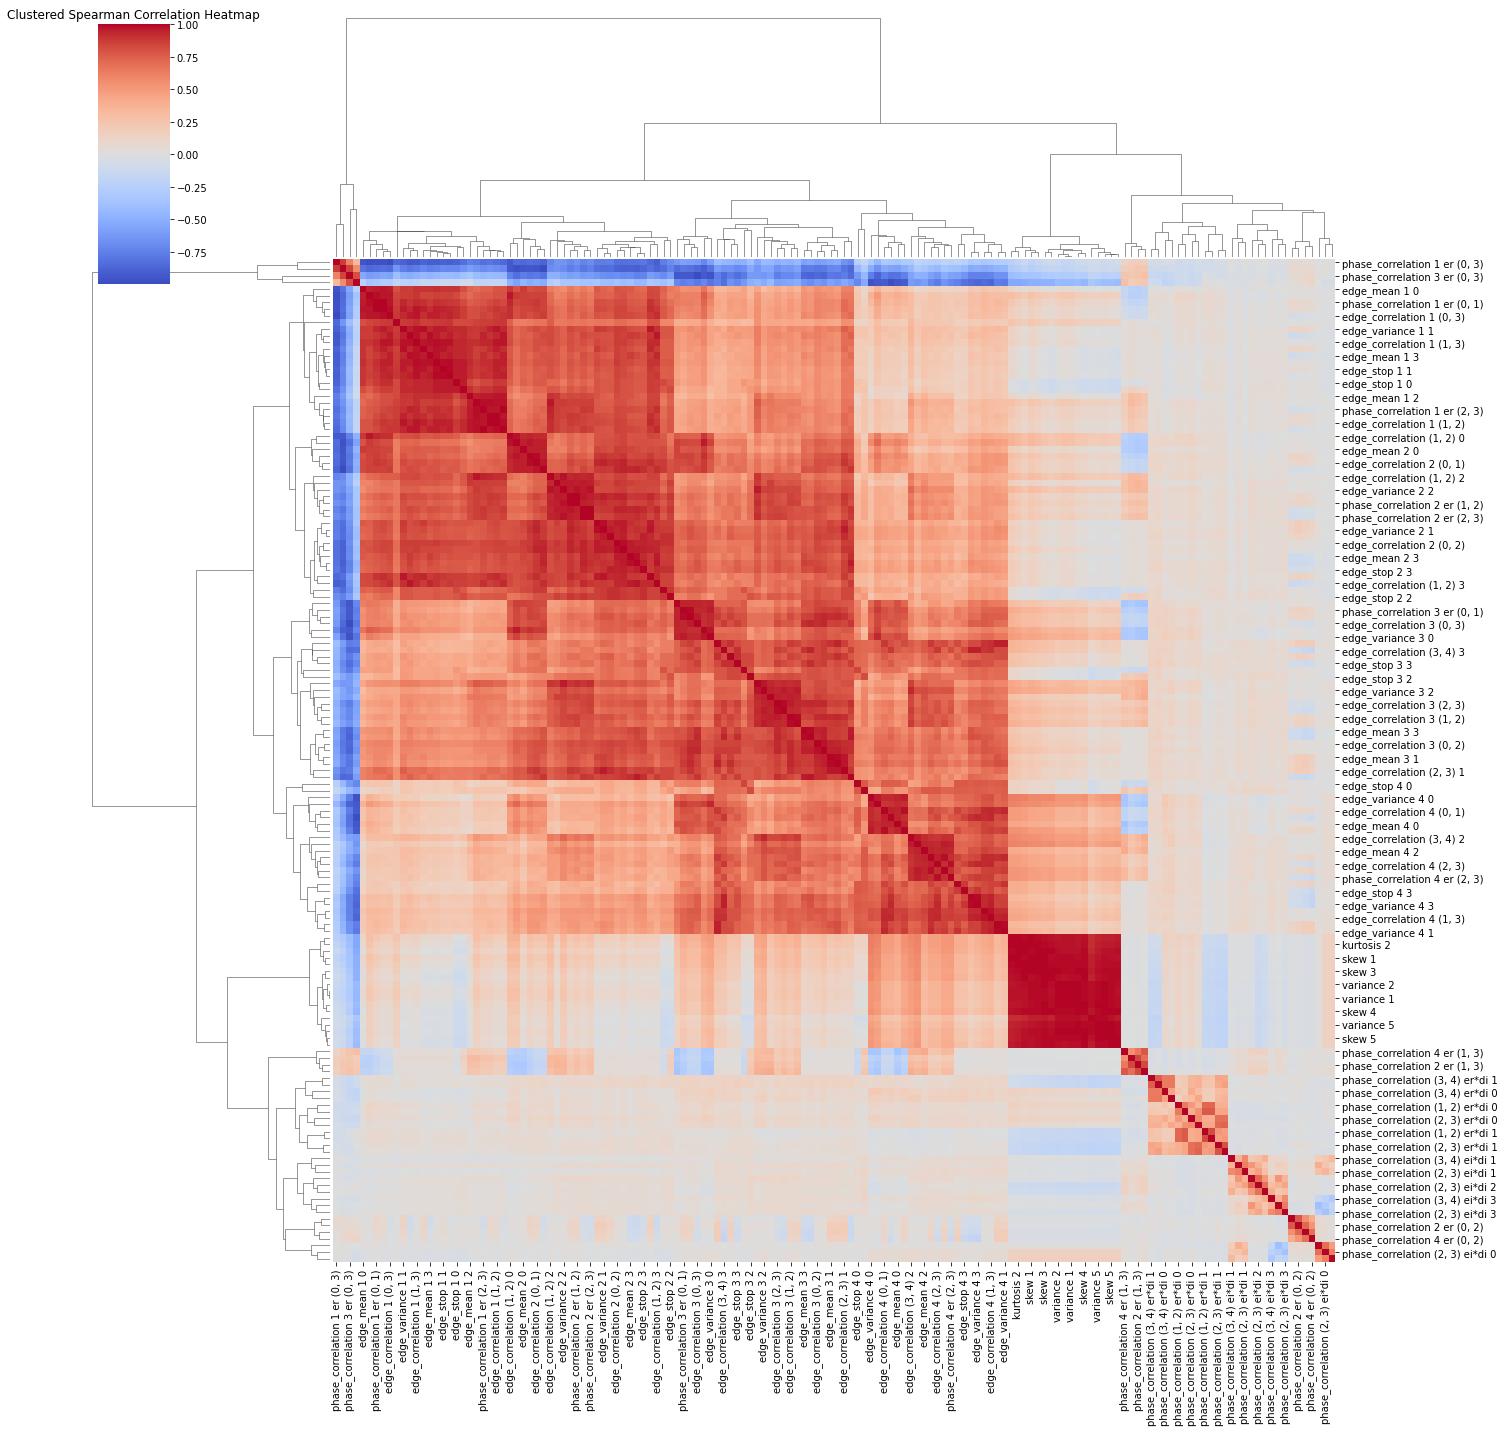

In [10]:
import seaborn as sns
# Assuming scaled_array contains your scaled features
df = pd.DataFrame(scaled_array, columns=ostat_labels)  # Assuming ostat_labels are your feature names
spearman_corr_matrix = df.corr(method='spearman')
sns.clustermap(spearman_corr_matrix, method='average', cmap='coolwarm', figsize=(20, 20))
plt.title('Clustered Spearman Correlation Heatmap')
plt.show()


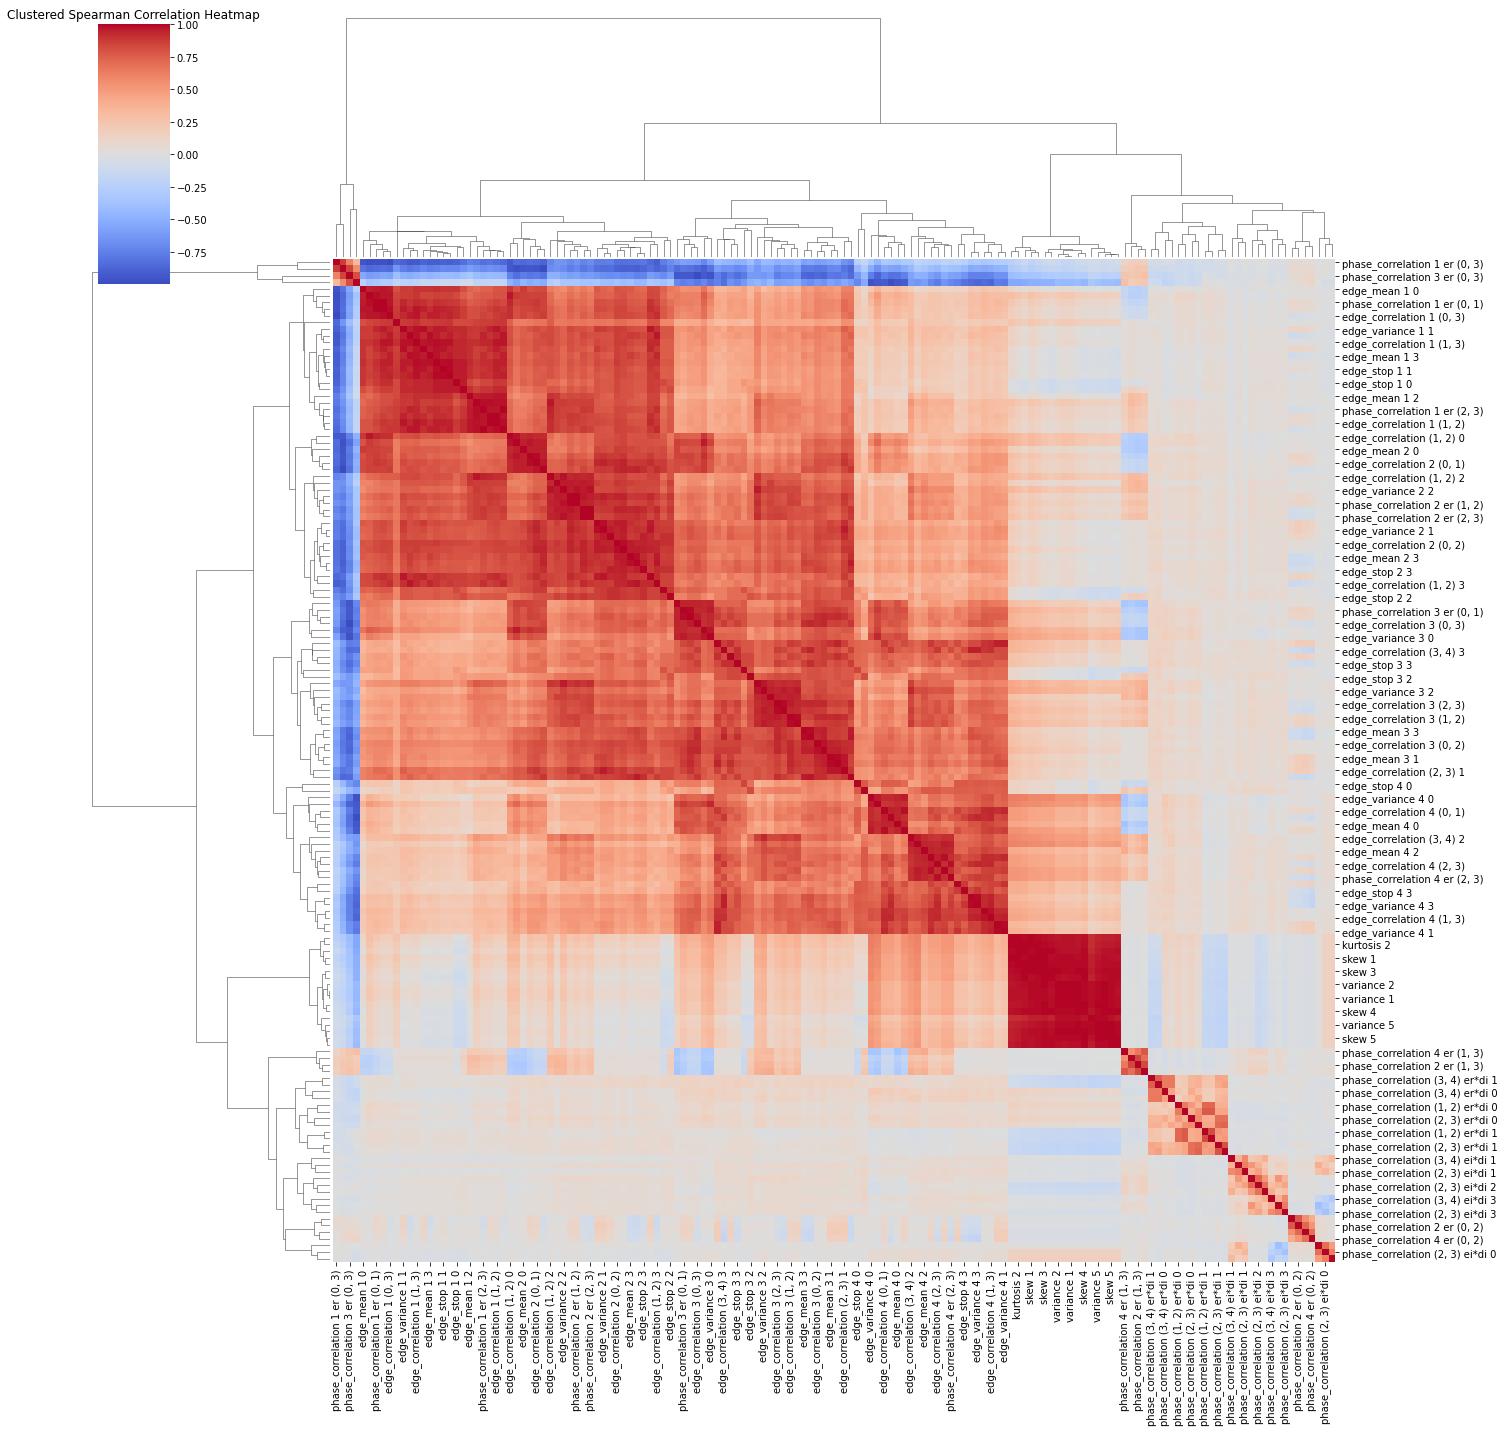

['phase_correlation 1 er (0, 3)' 'phase_correlation 2 er (0, 3)'
 'phase_correlation 3 er (0, 3)' 'phase_correlation 4 er (0, 3)'
 'edge_mean 1 0' 'edge_variance 1 0' 'phase_correlation 1 er (0, 1)'
 'edge_correlation 1 (0, 1)' 'edge_correlation 1 (0, 3)'
 'bandpass_variance 0' 'edge_variance 1 1' 'edge_variance 1 3'
 'edge_correlation 1 (1, 3)' 'edge_mean 1 1' 'edge_mean 1 3'
 'edge_correlation 1 (0, 2)' 'edge_stop 1 1' 'edge_stop 1 3'
 'edge_stop 1 0' 'edge_stop 1 2' 'edge_mean 1 2' 'edge_variance 1 2'
 'phase_correlation 1 er (2, 3)' 'phase_correlation 1 er (1, 2)'
 'edge_correlation 1 (1, 2)' 'edge_correlation 1 (2, 3)'
 'edge_correlation (1, 2) 0' 'edge_variance 2 0' 'edge_mean 2 0'
 'phase_correlation 2 er (0, 1)' 'edge_correlation 2 (0, 1)'
 'edge_correlation 2 (0, 3)' 'edge_correlation (1, 2) 2' 'edge_mean 2 2'
 'edge_variance 2 2' 'edge_correlation 2 (1, 2)'
 'phase_correlation 2 er (1, 2)' 'edge_correlation 2 (2, 3)'
 'phase_correlation 2 er (2, 3)' 'edge_mean 2 1' 'edge_vari

In [23]:
cluster_grid = sns.clustermap(spearman_corr_matrix, method='average', cmap='coolwarm', figsize=(20, 20))
plt.title('Clustered Spearman Correlation Heatmap')
plt.show()

# Get the order of rows based on clustering
new_row_order = cluster_grid.dendrogram_row.reordered_ind
# Get the order of columns based on clustering
new_col_order = cluster_grid.dendrogram_col.reordered_ind

# Get the reordered feature names
reordered_features = np.array(ostat_labels)[new_row_order]

# Now you can inspect or print out reordered_features to see how features are grouped.
print(reordered_features)

In [10]:
from torch.utils.data import Dataset, DataLoader

class StatisticsDataset(Dataset):
    def __init__(self, statistics_tensor, labels_tensor):
        self.statistics = statistics_tensor
        self.labels = labels_tensor
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.statistics[idx], self.labels[idx]

# Create the dataset object
statistics_dataset = StatisticsDataset(statistics_tensor, labels_tensor)

batches = 100
class_statistics_dataloader = DataLoader(statistics_dataset, batch_size=batches, shuffle=True)

In [11]:
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(150, 100)
        self.layer2 = nn.Linear(100, 75)
        self.layer3 = nn.Linear(75, 50)
        self.layer4 = nn.Linear(50, 47)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=75, bias=True)
  (layer3): Linear(in_features=75, out_features=50, bias=True)
  (layer4): Linear(in_features=50, out_features=47, bias=True)
)


In [12]:
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        self.layer1 = nn.Linear(150, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 47)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(F.relu(self.layer2(x)))
        x = F.relu(self.layer3(x))
        x = self.bn2(x)
        x = self.dropout(F.relu(self.layer4(x)))
        x = F.relu(self.layer5(x))
        x = self.layer6(x)
        return x


In [27]:
print(ostat_labels[3])

variance 1


## Training loop

In [13]:
from torch.nn import CrossEntropyLoss
import torch.optim as optim
#model = EmbeddingModel()
model = ImprovedModel()

model.to(device)
classification_loss = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
training_loss = []
training_representation_loss = []
training_sparsity_loss = []
num_total_epochs = 0
#[s for s in stat_labels] #print all stats with details
model.train() # Set model to training mode
optimizer.zero_grad()
model.zero_grad()

In [14]:
# Training loop
num_epochs = 300 # Number of epochs for fine-tuning

# Initialize variables for tracking accuracy
total_samples = 0
correct_samples = 0

for epoch in range(num_epochs):
    for x_batch, y_batch in class_statistics_dataloader:  
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch = y_batch.squeeze()
        #print(y_batch.shape)
        # Forward pass
        outputs = model(x_batch)
        #print(outputs.shape)
        # Compute loss
        loss = classification_loss(outputs, y_batch)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += y_batch.size(0)
        correct_samples += (predicted == y_batch).sum().item()

    # Calculate accuracy for this epoch
    epoch_accuracy = 100 * correct_samples / total_samples

    # Logging
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Reset accuracy tracking variables for the next epoch
    total_samples = 0
    correct_samples = 0

Epoch [1/300], Loss: 3.8290, Accuracy: 2.58%
Epoch [2/300], Loss: 3.7740, Accuracy: 4.11%
Epoch [3/300], Loss: 3.7474, Accuracy: 5.66%
Epoch [4/300], Loss: 3.7126, Accuracy: 6.59%
Epoch [5/300], Loss: 3.4531, Accuracy: 7.50%
Epoch [6/300], Loss: 3.4071, Accuracy: 9.32%
Epoch [7/300], Loss: 3.5209, Accuracy: 9.51%
Epoch [8/300], Loss: 3.5957, Accuracy: 11.54%
Epoch [9/300], Loss: 3.2520, Accuracy: 12.00%
Epoch [10/300], Loss: 3.1646, Accuracy: 13.62%
Epoch [11/300], Loss: 3.0921, Accuracy: 14.15%
Epoch [12/300], Loss: 3.1509, Accuracy: 15.27%
Epoch [13/300], Loss: 3.2192, Accuracy: 15.63%
Epoch [14/300], Loss: 3.2798, Accuracy: 16.46%
Epoch [15/300], Loss: 2.9782, Accuracy: 16.61%
Epoch [16/300], Loss: 3.0188, Accuracy: 18.30%
Epoch [17/300], Loss: 3.0502, Accuracy: 19.12%
Epoch [18/300], Loss: 3.0203, Accuracy: 18.85%
Epoch [19/300], Loss: 2.9298, Accuracy: 20.29%
Epoch [20/300], Loss: 3.1112, Accuracy: 19.52%
Epoch [21/300], Loss: 2.8532, Accuracy: 20.38%
Epoch [22/300], Loss: 2.8727,

## Test accuracy

In [17]:
loading_transforms = transforms.Compose([
    transforms.CenterCrop(size=256),
    transforms.Grayscale(),
    transforms.ToTensor(),  # This will also convert the image from [0, 255] to [0.0, 1.0]
    transforms.ConvertImageDtype(torch.float32)
])

#use training set for now
test_dtd_dataset = torchvision.datasets.DTD(root='/home/gridsan/ckoevesdi/data/OT/dtd_torch/', split='val', 
                                            partition=10, 
                                       transform=loading_transforms, target_transform=None,
                                       download=False) #ah das datenset muss so aussehen wie es auf der website auch ist, deswegen kann man auch download false machen
# Define the batch size (Change this based on your requirements)
batch_size = 1

# Create a DataLoader
test_classification_dataloader = DataLoader(
    test_dtd_dataset,
    batch_size=batch_size,
    shuffle=False
)
tensor2pil_transform = transforms.ToPILImage()
print(len(test_dtd_dataset))

939


In [18]:
test_all_statistics = []

for j, (texture_batch, labels) in enumerate(test_classification_dataloader):
    # Assuming texture_batch has a shape of [20, 5, 1, 128, 128]
    #print(texture_batch.shape)
    output = texture_batch.to(device)
    output = torch.stack([output, output]).squeeze(1)
    #print(output.shape)
    #print(labels)
    statistics = brucy(output)  # This should output a tensor of shape [2, 150]
    statistics = statistics[0,:]
    #print(statistics[0,:])
    # You can now store these statistics, along with the label and original image index
    test_all_statistics.append({
        'statistics': statistics.cpu().numpy(),
        #'label': labels[i].item(),
        'original_image_index': labels.cpu().numpy()
    })

### Check feature importance

In [19]:
import numpy as np
test_statistics_array = np.array([item['statistics'] for item in test_all_statistics])

import pandas as pd

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(test_statistics_array)

# Calculate the correlation matrix
correlation_matrix = df.corr(method='spearman')

#print(correlation_matrix)

import pandas as pd

# Create DataFrame
df = pd.DataFrame(test_statistics_array)

# Calculate correlation matrix
correlation_matrix = df.corr()

# Set a threshold
threshold = 0.99  # Adjust this value as you see fit

# Find highly correlated features
highly_correlated_set = set()  # To keep track of pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
        #if correlation_matrix.iloc[i, j] > threshold:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            highly_correlated_set.add((colname1, colname2))

print("Highly Correlated Pairs:", highly_correlated_set)


Highly Correlated Pairs: {(12, 1), (3, 1), (11, 5), (11, 8), (7, 4), (16, 13), (107, 39), (12, 3), (12, 9), (12, 6), (9, 1), (8, 5), (13, 7), (6, 1), (13, 10), (14, 11), (9, 3), (15, 12), (10, 4), (9, 6), (10, 7), (15, 6), (15, 3), (15, 9), (105, 37), (6, 3)}


In [20]:
# To print out the feature names for the highly correlated indices
for index1, index2 in highly_correlated_set:
    print(f"Highly correlated pair: {ostat_labels[index1]}, {ostat_labels[index2]}")

# To check if any of the highly correlated pairs contain "mean"
contains_mean = any("variance" in (ostat_labels[index1] or ostat_labels[index2]) for index1, index2 in highly_correlated_set)

# Print result
print(f"Contains 'mean': {contains_mean}")

Highly correlated pair: variance 4, variance
Highly correlated pair: variance 1, variance
Highly correlated pair: kurtosis 3, kurtosis 1
Highly correlated pair: kurtosis 3, kurtosis 2
Highly correlated pair: skew 2, skew 1
Highly correlated pair: skew 5, skew 4
Highly correlated pair: phase_correlation 1 er (2, 3), edge_correlation 1 (2, 3)
Highly correlated pair: variance 4, variance 1
Highly correlated pair: variance 4, variance 3
Highly correlated pair: variance 4, variance 2
Highly correlated pair: variance 3, variance
Highly correlated pair: kurtosis 2, kurtosis 1
Highly correlated pair: skew 4, skew 2
Highly correlated pair: variance 2, variance
Highly correlated pair: skew 4, skew 3
Highly correlated pair: kurtosis 4, kurtosis 3
Highly correlated pair: variance 3, variance 1
Highly correlated pair: variance 5, variance 4
Highly correlated pair: skew 3, skew 1
Highly correlated pair: variance 3, variance 2
Highly correlated pair: skew 3, skew 2
Highly correlated pair: variance 5,

In [21]:
pairs_with_mean = []  # To store the index pairs where at least one feature contains "mean"
for index1, index2 in highly_correlated_set:
    feature1 = ostat_labels[index1]
    feature2 = ostat_labels[index2]
    print(f"Highly correlated pair: {feature1}, {feature2}")
    
    if "variance" in feature1 or "variance" in feature2:
        pairs_with_mean.append((index1, index2))

# Print out the index pairs that contain "mean"
print(f"Index pairs with 'mean': {pairs_with_mean}")

Highly correlated pair: variance 4, variance
Highly correlated pair: variance 1, variance
Highly correlated pair: kurtosis 3, kurtosis 1
Highly correlated pair: kurtosis 3, kurtosis 2
Highly correlated pair: skew 2, skew 1
Highly correlated pair: skew 5, skew 4
Highly correlated pair: phase_correlation 1 er (2, 3), edge_correlation 1 (2, 3)
Highly correlated pair: variance 4, variance 1
Highly correlated pair: variance 4, variance 3
Highly correlated pair: variance 4, variance 2
Highly correlated pair: variance 3, variance
Highly correlated pair: kurtosis 2, kurtosis 1
Highly correlated pair: skew 4, skew 2
Highly correlated pair: variance 2, variance
Highly correlated pair: skew 4, skew 3
Highly correlated pair: kurtosis 4, kurtosis 3
Highly correlated pair: variance 3, variance 1
Highly correlated pair: variance 5, variance 4
Highly correlated pair: skew 3, skew 1
Highly correlated pair: variance 3, variance 2
Highly correlated pair: skew 3, skew 2
Highly correlated pair: variance 5,

In [22]:
for index1, index2 in pairs_with_mean:
    feature1 = ostat_labels[index1]
    feature2 = ostat_labels[index2]
    if "edge_variance" in feature1 or "edge_variance" in feature2:
        continue
    print(f"Highly correlated pair: {feature1}, {feature2}, {index1}, {index2}")

Highly correlated pair: variance 4, variance, 12, 1
Highly correlated pair: variance 1, variance, 3, 1
Highly correlated pair: variance 4, variance 1, 12, 3
Highly correlated pair: variance 4, variance 3, 12, 9
Highly correlated pair: variance 4, variance 2, 12, 6
Highly correlated pair: variance 3, variance, 9, 1
Highly correlated pair: variance 2, variance, 6, 1
Highly correlated pair: variance 3, variance 1, 9, 3
Highly correlated pair: variance 5, variance 4, 15, 12
Highly correlated pair: variance 3, variance 2, 9, 6
Highly correlated pair: variance 5, variance 2, 15, 6
Highly correlated pair: variance 5, variance 1, 15, 3
Highly correlated pair: variance 5, variance 3, 15, 9
Highly correlated pair: variance 2, variance 1, 6, 3


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Convert the list of dictionaries to a NumPy array or PyTorch tensor
test_statistics_array = np.array([item['statistics'] for item in test_all_statistics])
test_labels_array = np.array([item['original_image_index'] for item in test_all_statistics])
print(test_statistics_array.shape)

#scaler = StandardScaler()
#scaler = MinMaxScaler()
test_scaled_array = scaler.transform(test_statistics_array)

#print(test_scaled_array[:, 148])
#test_scaled_array = test_statistics_array
#np.random.shuffle(test_scaled_array[:, 86])
#print(test_scaled_array[:, 148])

# Convert NumPy arrays to PyTorch tensors
test_statistics_tensor = torch.tensor(test_scaled_array, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_array, dtype=torch.long)

from torch.utils.data import Dataset, DataLoader

class StatisticsDataset(Dataset):
    def __init__(self, statistics_tensor, labels_tensor):
        self.statistics = statistics_tensor
        self.labels = labels_tensor
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.statistics[idx], self.labels[idx]

# Create the dataset object
test_statistics_dataset = StatisticsDataset(test_statistics_tensor, test_labels_tensor)

batches = 80
test_class_statistics_dataloader = DataLoader(test_statistics_dataset, batch_size=batches, shuffle=False)

(939, 150)


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro

# Convert to DataFrame for easier manipulation
test_statistics_array = test_scaled_array
df = pd.DataFrame(test_statistics_array)

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set a threshold for correlation
threshold = 0.95

# Find highly correlated features
highly_correlated_set = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > threshold:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            highly_correlated_set.add((colname1, colname2))

print("Highly Correlated Pairs:", highly_correlated_set)

Highly Correlated Pairs: {(12, 4), (58, 56), (35, 33), (14, 13), (10, 6), (11, 5), (102, 34), (13, 8), (7, 1), (16, 13), (17, 5), (9, 1), (17, 14), (11, 7), (13, 1), (13, 10), (15, 7), (6, 4), (16, 6), (7, 3), (16, 15), (116, 56), (14, 8), (17, 7), (8, 4), (39, 37), (9, 3), (133, 81), (17, 16), (13, 3), (15, 0), (13, 12), (15, 9), (16, 8), (7, 5), (107, 37), (3, 1), (14, 10), (135, 83), (13, 5), (130, 78), (16, 1), (36, 34), (16, 10), (119, 59), (107, 39), (12, 6), (17, 11), (9, 7), (11, 4), (10, 8), (13, 7), (15, 4), (6, 1), (16, 3), (15, 13), (16, 12), (35, 25), (14, 5), (17, 4), (9, 0), (121, 61), (10, 1), (13, 9), (15, 6), (105, 37), (16, 14), (12, 1), (12, 10), (14, 7), (5, 4), (10, 3), (1, 0), (13, 11), (16, 7), (7, 4), (107, 27), (105, 39), (12, 3), (3, 0), (10, 5), (13, 4), (41, 20), (16, 9), (116, 41), (4, 1), (38, 33), (14, 11), (17, 13), (10, 7), (144, 96), (6, 3), (12, 7), (14, 4), (4, 3), (130, 63), (102, 19), (10, 9), (11, 8), (105, 27), (16, 4), (12, 0), (12, 9), (149, 1

In [25]:
model.eval()

# Initialize variables for tracking accuracy
total_samples = 0
correct_samples = 0
all_preds = []
all_labels = []
# Disable gradient calculation
with torch.no_grad():
    for x_batch, y_batch in test_class_statistics_dataloader:  
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch = y_batch.squeeze()
        
        # Forward pass
        outputs = model(x_batch)
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        total_samples += y_batch.size(0)
        correct_samples += (predicted == y_batch).sum().item()

# Calculate accuracy for the test set
test_accuracy = 100 * correct_samples / total_samples

print(f'Test Accuracy: {test_accuracy:.2f}%')

# Set the model back to training mode (optional if you continue training afterwards)
model.train()


Test Accuracy: 29.39%


ImprovedModel(
  (layer1): Linear(in_features=150, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=32, bias=True)
  (layer6): Linear(in_features=32, out_features=47, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Permutation Importance and permutation tests

In [26]:
# Function to compute test accuracy
import copy
def compute_test_accuracy(model, dataloader, device):
    model.eval()
    total_samples = 0
    correct_samples = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_batch = y_batch.squeeze()
            outputs = model(x_batch)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += y_batch.size(0)
            correct_samples += (predicted == y_batch).sum().item()
    return 100 * correct_samples / total_samples

In [27]:
##Mal zwei auf einmal vertauschen

test_statistics_array = np.array([item['statistics'] for item in test_all_statistics])
test_labels_array = np.array([item['original_image_index'] for item in test_all_statistics])
test_scaled_array = scaler.transform(test_statistics_array)
#np.random.shuffle(test_scaled_array[:, 2])
#np.random.shuffle(test_scaled_array[:, 0])
# Convert NumPy arrays to PyTorch tensors
test_statistics_tensor = torch.tensor(test_scaled_array, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_array, dtype=torch.long)

# Create the dataset object
test_statistics_dataset = StatisticsDataset(test_statistics_tensor, test_labels_tensor)

batches = 80
test_class_statistics_dataloader_permuted = DataLoader(test_statistics_dataset, batch_size=batches, shuffle=False)

permuted_accuracy = compute_test_accuracy(model, test_class_statistics_dataloader_permuted, device)


In [28]:
print(permuted_accuracy)

29.39297124600639


In [29]:
test_statistics_array = np.array([item['statistics'] for item in test_all_statistics])
test_labels_array = np.array([item['original_image_index'] for item in test_all_statistics])
test_scaled_array = scaler.transform(test_statistics_array)
np.random.shuffle(test_scaled_array[:, 3])
np.random.shuffle(test_scaled_array[:, 6])
np.random.shuffle(test_scaled_array[:, 9])
np.random.shuffle(test_scaled_array[:,12])
np.random.shuffle(test_scaled_array[:,15])
np.random.shuffle(test_scaled_array[:, 1])
np.random.shuffle(test_scaled_array[:, 7])
#np.random.shuffle(test_scaled_array[:, 93])
#np.random.shuffle(test_scaled_array[:,16])
 # Convert NumPy arrays to PyTorch tensors
test_statistics_tensor = torch.tensor(test_scaled_array, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_array, dtype=torch.long)

# Create the dataset object
test_statistics_dataset = StatisticsDataset(test_statistics_tensor, test_labels_tensor)

batches = 80
test_class_statistics_dataloader_permuted = DataLoader(test_statistics_dataset, batch_size=batches, shuffle=False)

permuted_accuracy = compute_test_accuracy(model, test_class_statistics_dataloader_permuted, device)
print(permuted_accuracy)

24.494142705005324


In [30]:
# Original test accuracy
original_test_accuracy = compute_test_accuracy(model, test_class_statistics_dataloader, device)
print(f'Original Test Accuracy: {original_test_accuracy:.2f}%')


Original Test Accuracy: 29.39%


In [31]:
import numpy as np

# Calculate original accuracy
original_test_accuracy = compute_test_accuracy(model, test_class_statistics_dataloader, device)
print(f'Original Test Accuracy: {original_test_accuracy:.2f}%')

n_features = 150  
n_permutations = 30  
permuted_accuracies = np.zeros((n_features, n_permutations))

for i in range(n_features):
    for j in range(n_permutations):
        # Existing code to permute one feature and get permuted_accuracy
        test_statistics_array = np.array([item['statistics'] for item in test_all_statistics])
        test_labels_array = np.array([item['original_image_index'] for item in test_all_statistics])
        test_scaled_array = scaler.transform(test_statistics_array)
        np.random.shuffle(test_scaled_array[:, i])
         # Convert NumPy arrays to PyTorch tensors
        test_statistics_tensor = torch.tensor(test_scaled_array, dtype=torch.float32)
        test_labels_tensor = torch.tensor(test_labels_array, dtype=torch.long)

        # Create the dataset object
        test_statistics_dataset = StatisticsDataset(test_statistics_tensor, test_labels_tensor)

        batches = 80
        test_class_statistics_dataloader_permuted = DataLoader(test_statistics_dataset, batch_size=batches, shuffle=False)

        permuted_accuracy = compute_test_accuracy(model, test_class_statistics_dataloader_permuted, device)
        permuted_accuracies[i, j] = permuted_accuracy

mean_drops = np.mean(original_test_accuracy - permuted_accuracies, axis=1)
std_drops = np.std(original_test_accuracy - permuted_accuracies, axis=1)

for i in range(n_features):
    mean_drop = mean_drops[i]
    std_drop = std_drops[i]
    print(f"Feature {i}: Mean drop = {mean_drop:.2f}, Std drop = {std_drop:.2f}")
    if mean_drop - std_drop > 0 or mean_drop + std_drop < 0:
        print(f"Feature {i} has statistically significant importance.")


Original Test Accuracy: 29.39%
Feature 0: Mean drop = 2.90, Std drop = 0.58
Feature 0 has statistically significant importance.
Feature 1: Mean drop = 0.50, Std drop = 0.39
Feature 1 has statistically significant importance.
Feature 2: Mean drop = 1.77, Std drop = 0.61
Feature 2 has statistically significant importance.
Feature 3: Mean drop = 0.70, Std drop = 0.52
Feature 3 has statistically significant importance.
Feature 4: Mean drop = 0.64, Std drop = 0.45
Feature 4 has statistically significant importance.
Feature 5: Mean drop = 0.63, Std drop = 0.41
Feature 5 has statistically significant importance.
Feature 6: Mean drop = 1.23, Std drop = 0.44
Feature 6 has statistically significant importance.
Feature 7: Mean drop = 0.15, Std drop = 0.38
Feature 8: Mean drop = 0.39, Std drop = 0.35
Feature 8 has statistically significant importance.
Feature 9: Mean drop = 1.24, Std drop = 0.56
Feature 9 has statistically significant importance.
Feature 10: Mean drop = 0.94, Std drop = 0.41
Featu

In [32]:
# Most important stats
high_drop_indices = np.where(mean_drops > 4)[0]

print("Indices where mean drop is greater than 3:", high_drop_indices)
high_indices = [26, 51, 62, 65, 69, 73, 77, 84, 87, 92, 93, 97]
high_indices = high_drop_indices
for i in high_indices:
    print(f"Index {i}: {ostat_labels[i]}")



Indices where mean drop is greater than 3: [43 51 62 87 92 93]
Index 43: edge_stop 2 0
Index 51: edge_stop 2 2
Index 62: edge_mean 3 0
Index 87: edge_mean 4 1
Index 92: edge_stop 4 2
Index 93: edge_mean 4 3


# 

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


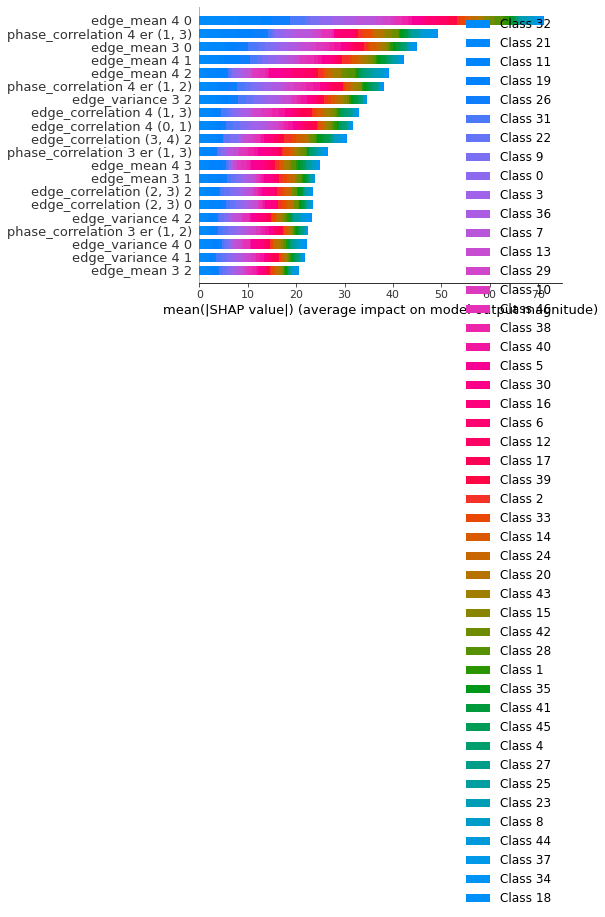

In [32]:
import shap

# Initialize your trained model (make sure it's on the same device as your data)
# Assuming your model is already on the device and named 'model'

# Make sure the background_data is on the same device as the model
background_data = statistics_tensor.to(device)  # Replace 'device' with your actual device, e.g., 'cuda'

# Initialize SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background_data)

# Choose some test data to explain and make sure it is on the same device as your model
test_data = test_statistics_tensor.to(device)  # Replace 'device' with your actual device, e.g., 'cuda'

# Compute SHAP values
shap_values = explainer.shap_values(test_data)

# Convert to numpy array for plotting
#shap_values_np = [s.cpu().numpy() for s in shap_values]

# Plotting the SHAP values with feature names
shap.summary_plot(shap_values, test_data.cpu().numpy(), plot_type="bar", feature_names=ostat_labels)

In [55]:
print(ostat_labels[93])

edge_mean 4 3


In [46]:
#Finde den index für die statistik

try:
    index = ostat_labels.index("phase_correlation (1, 2) er*di 1")
    print(f"The index of 'phase_correlation 4 er (0,2)' is {index}")
except ValueError:
    print("'phase_correlation 4 er (0,2)' is not in ostat_labels.")


The index of 'phase_correlation 4 er (0,2)' is 111


In [51]:
import numpy as np

# Create a 5x5 matrix with integer elements
matrix = np.array([
    [1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15],
    [16, 17, 18, 19, 20],
    [21, 22, 23, 24, 25]
])

np.random.shuffle(matrix[:,2])

In [52]:
print(matrix)

[[ 1  2  8  4  5]
 [ 6  7 23  9 10]
 [11 12 13 14 15]
 [16 17  3 19 20]
 [21 22 18 24 25]]
